In [4]:
"""
Simplified Execution Script for Multidimensional Marine Heatwave Detector (xrMHW)
================================================================================
Instructions:
1. Modify the "USER CONFIGURATION" section with your data.
2. Run the script.
3. Open the link that appears in the console to view progress.
"""

import xarray as xr
import numpy as np
from dask.distributed import Client
import sys
import os

In [2]:
# clone the repository
!conda install git -y
!git clone https://github.com/Gabo2000s/xarray_MHW-xrMHW-.git

Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gabo2\miniforge3\envs\geo_env

  added / updated specs:
    - git


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.6.1              |       hf411b9b_1         8.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.9 MB

The following packages will be UPDATED:

  openssl                                  3.6.0-h725018a_0 --> 3.6.1-hf411b9b_1 



openssl-3.6.1        | 8.9 MB    |            |   0% 
openssl-3.6.1        | 8.9 MB    |            |   0% 
openssl-3.6.1        | 8.9 MB    | #1         |  12% 
openssl-3.6.1        | 8.9 MB    | ###7       |  38% 
openssl-3.6.1        | 8.9 MB    | #####9     |  60% 
openssl-3.



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda


fatal: destination path 'xarray_MHW-xrMHW-' already exists and is not an empty directory.


In [5]:
repo_folder = r"D:/Articulos/MHW/MHW_Code/xarray_MHW-xrMHW-" ## chose the folder where the repository is cloned
if repo_folder not in sys.path:
    sys.path.append(os.path.abspath(repo_folder))
				
import xrMHW

**Import and check data variable and dimension names**

In [6]:
xr.open_dataset(r"E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped.nc")

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 15340, latitude: 199, longitude: 160)
Coordinates:
  * time          (time) datetime64[ns] 123kB 1982-01-01 ... 2023-12-31
  * latitude      (latitude) float32 796B 22.08 22.12 22.17 ... 31.92 31.98
  * longitude     (longitude) float32 640B -118.0 -117.9 ... -110.1 -110.0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 2GB ...
Attributes:
    source:                    AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, GO...
    references:                Donlon, C.J., Martin, M., Stark, J.D., Roberts...
    comment:                   WARNING Some applications are unable to proper...
    title:                     Global SST & Sea Ice Analysis, L4 OSTIA, 0.05 ...
    history:                   Created from sst.nc; obs_anal.nc; seaice.nc
    Conventions:               CF-1.4, ACDD-1.3
    institution:               UKMO
    copernicusmarine_version:  2.2.4

**Section 1: User Data Configuration**:

In [7]:
# FILES 
# Full path to the NetCDF file containing your temperature data
INPUT_FILE = r"E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped.nc"

# Path where you want to save the result (must end in .nc)
OUTPUT_FILE = r"E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped_MHW_test.nc"

# DATA 
# Exact name of the temperature variable inside the file (e.g., 'sst', 'analysed_sst')
VAR_NAME = 'analysed_sst'

# CLIMATOLOGY DEFINITION (THE "BASELINE") 
# Base period to calculate the historical average
CLIM_START = 1981
CLIM_END = 2020

# HEATWAVE PARAMETERS 
PERCENTILE = 90    # Threshold (90 is standard for MHW)
MIN_DURATION = 5     # Minimum consecutive days to count as an event
JOIN_GAPS = True  # Join events if interrupted briefly? (Recommended: True)
MAX_GAP_DAYS = 2     # Maximum "non-mhw" days allowed within an event
GAP_PROCESSING = 'post-processing' ## post-processing apply the same method than Hobaday et al. (2016) for joint the gaps

# PERFORMANCE & CHUNKING
# Number of CPU cores of your computer to use.
NUM_CORES = 10     

# Chunk size controls how data is split to avoid RAM memory overflow. 
# RULE: 'time' MUST be -1 (load all time steps).
# Adjust 'lat'/'lon' (or 'latitude'/'longitude') based on your specific file dimension names.
# Smaller numbers = less RAM usage per core.
CHUNK_CONFIG    = {'time': -1, 'latitude': 50, 'longitude': 50}


**Section 2: Automatic Execution (DO NOT EDIT BELOW)**

In [8]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print(" STARTING MARINE HEATWAVE DETECTOR (xrMHW)")
    print("="*60)

    # 1. Start Dask Client (Parallelism)
    # --------------------------------------------------------------------------
    print(f"... Starting engine with {NUM_CORES} cores.")
    # threads_per_worker=1 avoids conflicts with numerical libraries
    client = Client(n_workers=NUM_CORES, threads_per_worker=1)
    
    print("\n" + "-"*60)
    print(f" >> VIEW PROGRESS BAR HERE:  {client.dashboard_link}")
    print("-"*60 + "\n")

    try:
        # 2. Load Data
        # ----------------------------------------------------------------------
        print(f"... Loading file: {INPUT_FILE}")
        print(f"... Applying chunks: {CHUNK_CONFIG}")
        
        # Open the dataset with user-defined chunks
        # This allows Dask to handle files larger than RAM
        ds = xr.open_dataset(INPUT_FILE, chunks=CHUNK_CONFIG)

        # 3. Run Algorithm (xrMHW)
        # ----------------------------------------------------------------------
        print(f"... Detecting events (Ref: {CLIM_START}-{CLIM_END})...")
        print("    This may take a while depending on file size.")
        
        ds_mhw = xrMHW.xrMHW_func(
            ds, 
            temp_var_name=VAR_NAME, 
            clim_period=(CLIM_START, CLIM_END),
            pctile=PERCENTILE,
            min_duration=MIN_DURATION,
            join_across_gaps=JOIN_GAPS,
            max_gap=MAX_GAP_DAYS, 
												join_method=GAP_PROCESSING
        )

        # 4. Save Results
        # ----------------------------------------------------------------------
        print(f"... Saving results to: {OUTPUT_FILE}")
        
        # Compression configuration to reduce final file size
        comp = {'zlib': True, 'complevel': 5, 'dtype': 'float32', '_FillValue': np.nan}
        encoding = {var: comp for var in ds_mhw.data_vars}
        
        # The .to_netcdf() function triggers the actual calculation in Dask
        ds_mhw.to_netcdf(OUTPUT_FILE, encoding=encoding)
        
        print("\n" + "="*60)
        print(" PROCESS COMPLETED SUCCESSFULLY!")
        print(f" File saved: {OUTPUT_FILE}")
        print("="*60)

    except FileNotFoundError:
        print(f"\n[ERROR] Input file not found: {INPUT_FILE}")
        print("Please check the path in the CONFIGURATION section.")
    except KeyError as e:
        print(f"\n[ERROR] Dimension or Variable mismatch: {e}")
        print(f"Check that VAR_NAME matches the file.")
        print(f"Also check that keys in CHUNK_CONFIG (like 'lat'/'lon') match the dimension names in your file (e.g., maybe they are 'latitude'/'longitude').")
    except Exception as e:
        print(f"\n[UNEXPECTED ERROR] {e}")
    finally:
        # Close the client to free up memory
        client.close()
        print("\nEngine shut down.")


 STARTING MARINE HEATWAVE DETECTOR (xrMHW)
... Starting engine with 10 cores.

------------------------------------------------------------
 >> VIEW PROGRESS BAR HERE:  http://127.0.0.1:8787/status
------------------------------------------------------------

... Loading file: E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped.nc
... Applying chunks: {'time': -1, 'latitude': 50, 'longitude': 50}
... Detecting events (Ref: 1981-2020)...
    This may take a while depending on file size.
... Saving results to: E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped_MHW_test.nc


C:\Users\gabo2\AppData\Local\Temp\ipykernel_22736\1674736934.py:24: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(INPUT_FILE, chunks=CHUNK_CONFIG)
C:\Users\gabo2\AppData\Local\Temp\ipykernel_22736\1674736934.py:24: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(INPUT_FILE, chunks=CHUNK_CONFIG)



 PROCESS COMPLETED SUCCESSFULLY!
 File saved: E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped_MHW_test.nc

Engine shut down.


**Exploration of the data**

In [9]:
ds = xr.open_dataset(r'E:\MHW_SCC\MHW_Detrended_SCC\OSTIA_SCC_Raw_Cropped_MHW_test.nc')

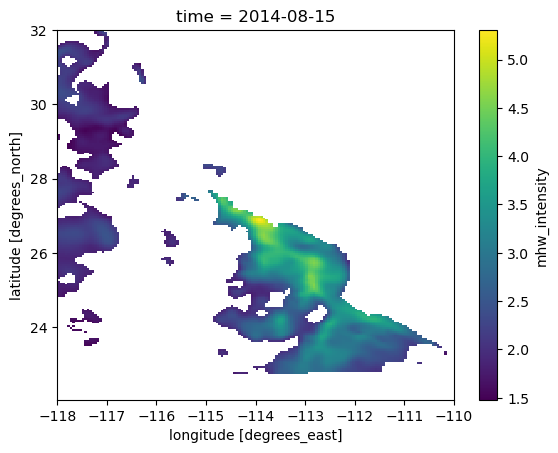

In [10]:
## plot example of one day (Marine Heatwave Intensity)

ds['mhw_intensity'].sel(time='2014-08-15').plot()

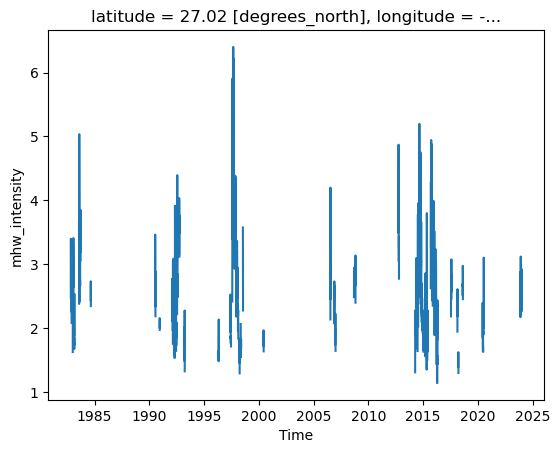

In [11]:
## plot example of a time series of one point latitude and longitude

ds['mhw_intensity'].sel(latitude=27, longitude=-115, method='nearest').plot()